In [ ]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

In [ ]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].

# Apply necessary image transfromations here 

transform = transforms.Compose([#torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                #torchvision.transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [ ]:
train_data_dir = '/content/drive/My Drive/Datasets/3/train' # put path of training dataset
val_data_dir = '/content/drive/My Drive/Datasets/3/val' # put path of validation dataset
test_data_dir = '/content/drive/My Drive/Datasets/3/test' # put path of test dataset

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=8)

valset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=8,
                                         shuffle=False, num_workers=8)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=8)

In [ ]:
########################################################################
# Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [ ]:
num_epochs = 50         # desired number of training epochs.
learning_rate = 0.001

In [ ]:
# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,
   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=5)
        self.fc3 = nn.Linear(in_features=512, out_features=33)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x


In [ ]:
################### DO NOT EDIT THE BELOW CODE!!! #######################

#net = ResNet()
net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

In [ ]:
import torch.optim as optim

In [ ]:
########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

4123425  parameters


In [ ]:
########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))

In [ ]:
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
                                    100 * correct / total))
    return (100 * correct / total)

In [ ]:
#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [ ]:
########################################################################
# class-wise accuracy
def classwise_test(testloader, model):
    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
values = [5e-5, 7.5e-5, 1e-4, 2.5e-4, 3.75e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]

results = open('/content/drive/My Drive/Models/WD_Results.txt', mode='w')
for i in range(len(values)):

  net = Net()

# transfer the model to GPU
  if torch.cuda.is_available():
    net = net.cuda()

  opt_val = values[i]
  optimizerx = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=opt_val)


  print('Optimiser Weight Decay:' + str(opt_val))
  print('Start Training')
  os.makedirs('./models', exist_ok=True)

  train_accs = []
  test_accs = []

  for epoch in range(num_epochs):  # loop over the dataset multiple times
      print('epoch ', epoch + 1)
      train(epoch, trainloader, optimizerx, criterion)
      train_acc = test(trainloader, net)
      test_acc = test(valloader, net)
      train_accs.append(train_acc)
      test_accs.append(test_acc)
      #classwise_test(valloader, net)
      # save model checkpoint 
      torch.save(net.state_dict(), './models/model-'+str(epoch)+'.pth')      

  print('performing test')
  acc = test(testloader, net)
  classwise_test(testloader, net)

  print('Finished Training')

  print(train_accs)
  print(test_accs)

  results.write(str(train_accs))
  results.write(str(train_accs))
  results.write('Weight Decay: ' + str(opt_val) + " Accuracy: " + str(acc) + '%')
  torch.save(net.state_dict(), '/content/drive/My Drive/Models/Optimiser_' + str(opt_val) + '.pth')

results.close()

  0%|          | 0/1650 [00:00<?, ?it/s]

Optimiser Weight Decay:0.01
Start Training
epoch  1


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 1 training loss: 3.203


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 17 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 18 %
epoch  2


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 2 training loss: 2.899


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 20 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 19 %
epoch  3


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 3 training loss: 2.763


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 24 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 22 %
epoch  4


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 4 training loss: 2.668


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 28 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 26 %
epoch  5


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 5 training loss: 2.588


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 29 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 28 %
epoch  6


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 6 training loss: 2.534


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %
epoch  7


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 7 training loss: 2.485


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 32 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %
epoch  8


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 8 training loss: 2.430


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 30 %
epoch  9


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 9 training loss: 2.399


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 32 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 30 %
epoch  10


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 10 training loss: 2.358


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 33 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 30 %
epoch  11


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 11 training loss: 2.329


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 34 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 32 %
epoch  12


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 12 training loss: 2.293


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 33 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 32 %
epoch  13


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 13 training loss: 2.265


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 35 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 32 %
epoch  14


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 14 training loss: 2.232


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 37 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 33 %
epoch  15


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 15 training loss: 2.211


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 34 %
epoch  16


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 16 training loss: 2.188


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 35 %
epoch  17


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 17 training loss: 2.159


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 34 %
epoch  18


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 18 training loss: 2.143


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 33 %
epoch  19


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 19 training loss: 2.118


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 36 %
epoch  20


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 20 training loss: 2.099


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 35 %
epoch  21


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 21 training loss: 2.081


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 37 %
epoch  22


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 22 training loss: 2.060


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %
epoch  23


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 23 training loss: 2.040


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %
epoch  24


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 24 training loss: 2.031


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %
epoch  25


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 25 training loss: 2.016


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %
epoch  26


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 26 training loss: 2.001


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %
epoch  27


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 27 training loss: 1.987


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %
epoch  28


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 28 training loss: 1.969


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %
epoch  29


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 29 training loss: 1.957


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %
epoch  30


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 30 training loss: 1.949


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 36 %
epoch  31


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 31 training loss: 1.934


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 47 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %
epoch  32


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 32 training loss: 1.924


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 47 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %
epoch  33


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 33 training loss: 1.912


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 47 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %
epoch  34


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 34 training loss: 1.891


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 48 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %
epoch  35


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 35 training loss: 1.888


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 50 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  36


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 36 training loss: 1.886


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 46 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 40 %
epoch  37


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 37 training loss: 1.878


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 47 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %
epoch  38


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 38 training loss: 1.873


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 48 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %
epoch  39


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 39 training loss: 1.853


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %
epoch  40


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 40 training loss: 1.851


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 48 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %
epoch  41


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 41 training loss: 1.837


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 50 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  42


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 42 training loss: 1.821


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 48 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %
epoch  43


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 43 training loss: 1.819


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 50 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  44


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 44 training loss: 1.808


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 51 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %
epoch  45


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 45 training loss: 1.798


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 50 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  46


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 46 training loss: 1.786


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 50 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %
epoch  47


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 47 training loss: 1.793


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 51 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  48


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 48 training loss: 1.772


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 49 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %
epoch  49


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 49 training loss: 1.766


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 51 %


  0%|          | 0/1650 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %
epoch  50


  0%|          | 0/1650 [00:00<?, ?it/s]

epoch 50 training loss: 1.759


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 55 %


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %
performing test


  0%|          | 0/413 [00:00<?, ?it/s]

Accuracy of the network on the test images: 47 %


100%|██████████| 413/413 [00:04<00:00, 91.33it/s] 


Accuracy of arctic_fox : 65 %
Accuracy of     barrel :  2 %
Accuracy of     cannon : 23 %
Accuracy of      chime : 29 %
Accuracy of      cliff : 67 %
Accuracy of       clog : 29 %
Accuracy of      crate : 59 %
Accuracy of    cuirass : 39 %
Accuracy of     dugong : 73 %
Accuracy of        ear : 45 %
Accuracy of frying_pan : 36 %
Accuracy of harvestman : 60 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 31 %
Accuracy of     hotdog : 55 %
Accuracy of       iPod : 56 %
Accuracy of  jellyfish : 69 %
Accuracy of  miniskirt : 35 %
Accuracy of    missile : 32 %
Accuracy of mixing_bowl : 35 %
Accuracy of   nematode : 42 %
Accuracy of newfoundland : 41 %
Accuracy of       oboe : 15 %
Accuracy of      robin : 60 %
Accuracy of     saluki : 48 %
Accuracy of school_bus : 81 %
Accuracy of theater_curtain : 78 %
Accuracy of three_toed_sloth : 72 %
Accuracy of tibetan_mastiff : 65 %
Accuracy of    upright : 56 %
Accuracy of walker_hound : 19 %
Accuracy of        wok : 31 %
Accuracy of wor

In [ ]:
results = open('/content/drive/My Drive/Models/WD_Results.txt', mode='r+')
results.readlines()
results.close()

In [ ]:
import matplotlib.pyplot as plt
import math

In [ ]:
wd_vals = [5e-5, 7.5e-5, 1e-4, 2.5e-4, 3.75e-4, 5e-4, 7.5e-4, 1e-3, 2.5e-3, 5e-3, 7.5e-3, 1e-2]
test_accs = [48, 54, 55, 57, 55, 56, 54, 54, 50, 51, 49, 42]
val_accs = [49, 53, 54, 55, 53, 55, 53, 53, 51, 51, 48, 43]

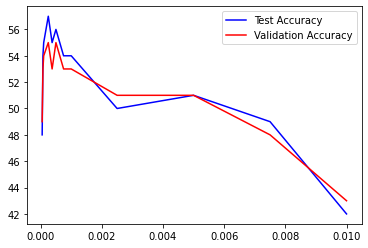

In [ ]:
test_acc = plt.plot(wd_vals, test_accs, label = 'Test Accuracy', color = 'b')
val_acc = plt.plot(wd_vals, val_accs, label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.show()

In [ ]:
log_vals = filter(math.log, wd_vals)
log_vals

In [ ]:
log_vals = []
for i in wd_vals:
  log_vals.append(math.log(i, 10))

print(log_vals)
print(type(log_vals))

[-4.30102999566398, -4.1249387366083, -3.999999999999999, -3.602059991327962, -3.4259687322722807, -3.301029995663981, -3.1249387366082995, -2.9999999999999996, -2.602059991327962, -2.301029995663981, -2.1249387366083, -1.9999999999999996]
<class 'list'>


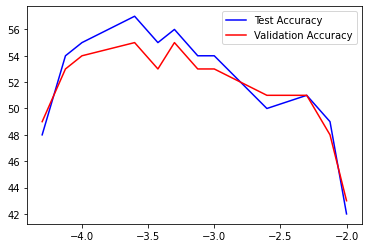

In [ ]:
log_test_acc = plt.plot(log_vals, test_accs, label = 'Test Accuracy', color = 'b')
log_val_acc = plt.plot(log_vals, val_accs, label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.show()

In [ ]:
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [ ]:
nums = []
for i in range(50):
  nums.append(i+1)
print(nums)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


In [ ]:
train_acc1 = [19.431818181818183, 23.318181818181817, 26.71212121212121, 30.386363636363637, 34.90909090909091, 37.553030303030305, 38.85606060606061, 42.61363636363637, 45.446969696969695, 47.29545454545455, 51.07575757575758, 51.40151515151515, 52.24242424242424, 59.39393939393939, 60.265151515151516, 62.11363636363637, 64.18181818181819, 67.49242424242425, 70.3030303030303, 73.08333333333333, 74.45454545454545, 78.5530303030303, 78.25757575757575, 83.12878787878788, 85.87121212121212, 88.42424242424242, 89.77272727272727, 92.40151515151516, 92.93939393939394, 95.75, 92.76515151515152, 97.4090909090909, 97.78787878787878, 98.1590909090909, 97.25, 98.95454545454545, 99.89393939393939, 99.78787878787878, 99.74242424242425, 99.77272727272727, 99.95454545454545, 99.89393939393939, 99.56818181818181, 97.37121212121212, 99.34848484848484, 99.87121212121212, 99.0, 99.56818181818181, 99.95454545454545, 99.82575757575758]
val_acc1 = [19.939393939393938, 22.242424242424242, 26.90909090909091, 29.21212121212121, 33.27272727272727, 35.484848484848484, 34.0, 37.78787878787879, 39.09090909090909, 40.90909090909091, 41.42424242424242, 42.696969696969695, 43.06060606060606, 47.121212121212125, 45.24242424242424, 46.36363636363637, 46.15151515151515, 47.60606060606061, 47.57575757575758, 47.696969696969695, 46.303030303030305, 47.06060606060606, 46.81818181818182, 46.84848484848485, 49.696969696969695, 48.78787878787879, 48.96969696969697, 48.121212121212125, 47.45454545454545, 48.45454545454545, 47.24242424242424, 49.63636363636363, 49.78787878787879, 50.333333333333336, 49.0, 50.75757575757576, 51.93939393939394, 51.333333333333336, 51.333333333333336, 52.303030303030305, 51.696969696969695, 51.484848484848484, 51.27272727272727, 48.75757575757576, 49.696969696969695, 52.27272727272727, 50.121212121212125, 51.15151515151515, 51.75757575757576, 52.03030303030303]

train_acc2 = [19.143939393939394, 21.886363636363637, 28.598484848484848, 31.977272727272727, 33.63636363636363, 36.89393939393939, 38.81818181818182, 42.43939393939394, 44.77272727272727, 46.63636363636363, 49.31060606060606, 48.03787878787879, 54.234848484848484, 55.03030303030303, 58.53787878787879, 59.234848484848484, 63.22727272727273, 66.51515151515152, 68.68939393939394, 70.3030303030303, 73.18181818181819, 75.8409090909091, 75.48484848484848, 80.02272727272727, 81.14393939393939, 83.21969696969697, 88.91666666666667, 84.0909090909091, 91.60606060606061, 92.5909090909091, 95.3409090909091, 93.1590909090909, 94.99242424242425, 95.56818181818181, 97.98484848484848, 94.26515151515152, 98.06818181818181, 99.28030303030303, 99.90151515151516, 99.6969696969697, 99.72727272727273, 99.92424242424242, 99.82575757575758, 93.58333333333333, 99.45454545454545, 99.87121212121212, 99.9469696969697, 99.96212121212122, 99.97727272727273, 99.93939393939394]
val_acc2 = [18.484848484848484, 20.696969696969695, 27.848484848484848, 29.939393939393938, 31.03030303030303, 33.18181818181818, 33.90909090909091, 37.03030303030303, 39.0, 40.36363636363637, 41.515151515151516, 40.78787878787879, 42.63636363636363, 43.84848484848485, 45.0, 44.57575757575758, 46.54545454545455, 49.36363636363637, 48.75757575757576, 48.75757575757576, 50.09090909090909, 48.15151515151515, 48.09090909090909, 48.09090909090909, 47.63636363636363, 50.42424242424242, 50.333333333333336, 47.84848484848485, 50.15151515151515, 49.63636363636363, 51.303030303030305, 49.42424242424242, 50.09090909090909, 49.878787878787875, 51.72727272727273, 48.696969696969695, 51.84848484848485, 50.78787878787879, 52.03030303030303, 52.57575757575758, 52.78787878787879, 52.878787878787875, 53.15151515151515, 47.333333333333336, 52.06060606060606, 52.63636363636363, 53.303030303030305, 53.42424242424242, 53.515151515151516, 53.63636363636363]

train_acc3 = [17.62121212121212, 20.825757575757574, 24.28030303030303, 28.106060606060606, 29.143939393939394, 31.727272727272727, 32.95454545454545, 31.939393939393938, 32.59848484848485, 33.583333333333336, 34.946969696969695, 33.68181818181818, 35.74242424242424, 37.515151515151516, 38.28030303030303, 39.77272727272727, 38.50757575757576, 38.196969696969695, 40.196969696969695, 38.53030303030303, 42.78030303030303, 43.42424242424242, 45.015151515151516, 43.79545454545455, 43.95454545454545, 44.34848484848485, 43.65151515151515, 45.03787878787879, 45.46212121212121, 42.17424242424242, 47.11363636363637, 47.31818181818182, 47.39393939393939, 48.75, 50.53030303030303, 46.083333333333336, 47.09848484848485, 48.18181818181818, 44.984848484848484, 48.803030303030305, 50.92424242424242, 48.75757575757576, 50.68181818181818, 51.71212121212121, 50.0, 50.46969696969697, 51.35606060606061, 49.72727272727273, 51.43181818181818, 55.24242424242424]
val_acc3 = [18.393939393939394, 19.272727272727273, 22.939393939393938, 26.151515151515152, 28.818181818181817, 31.181818181818183, 31.272727272727273, 30.151515151515152, 30.939393939393938, 30.636363636363637, 32.15151515151515, 32.0, 32.81818181818182, 33.93939393939394, 34.78787878787879, 35.666666666666664, 34.878787878787875, 33.90909090909091, 36.75757575757576, 35.24242424242424, 37.54545454545455, 38.60606060606061, 40.515151515151516, 40.0, 38.63636363636363, 38.57575757575758, 39.06060606060606, 39.39393939393939, 39.78787878787879, 36.36363636363637, 41.45454545454545, 40.27272727272727, 40.90909090909091, 41.60606060606061, 43.27272727272727, 40.15151515151515, 41.21212121212121, 41.515151515151516, 39.121212121212125, 41.27272727272727, 43.27272727272727, 42.121212121212125, 43.18181818181818, 44.21212121212121, 43.24242424242424, 42.36363636363637, 43.0, 42.39393939393939, 43.36363636363637, 45.75757575757576]


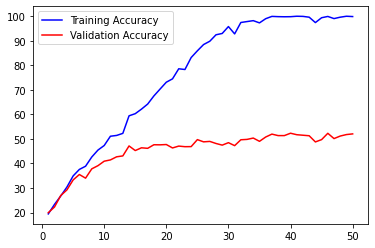

In [ ]:
train1 = plt.plot(nums, train_acc1, label = 'Training Accuracy', color = 'b')
val1 = plt.plot(nums, val_acc1, label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.show()

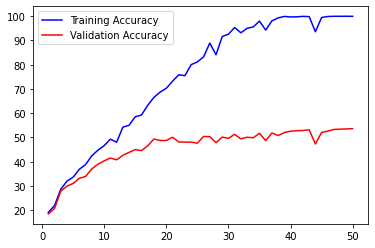

In [ ]:
train2 = plt.plot(nums, train_acc2, label = 'Training Accuracy', color = 'b')
val2 = plt.plot(nums, val_acc2, label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.show()

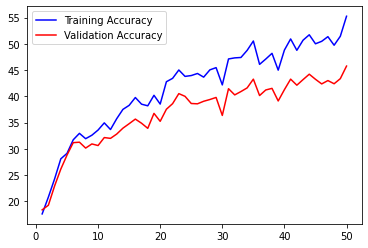

In [ ]:
train3 = plt.plot(nums, train_acc3, label = 'Training Accuracy', color = 'b')
val3 = plt.plot(nums, val_acc3, label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.show()